In [ ]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline


# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [ ]:
# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [ ]:
file = ('https://raw.githubusercontent.com/JorgeMendiProject/TFM/main/DatasetInterpolado.csv')
#Lectura de datos a partir del archivo .csv             

dataset = pd.read_csv(file,delimiter=';')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Fecha          216 non-null    object 
 1   TasaTPIB       216 non-null    float64
 2   EuriborM       216 non-null    float64
 3   ParoT          216 non-null    float64
 4   SalarioMedio   216 non-null    int64  
 5   IPC            216 non-null    float64
 6   CTotalConsumo  216 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 11.9+ KB


In [ ]:
#Se convierte la variable Fecha a Datetime

dataset['Fecha'] = pd.to_datetime(dataset['Fecha'], format='%d/%m/%Y')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          216 non-null    datetime64[ns]
 1   TasaTPIB       216 non-null    float64       
 2   EuriborM       216 non-null    float64       
 3   ParoT          216 non-null    float64       
 4   SalarioMedio   216 non-null    int64         
 5   IPC            216 non-null    float64       
 6   CTotalConsumo  216 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 11.9 KB


In [ ]:
#Se adecua al formato que tiene el archivo base, es decir, si hay meses se pone meses para que no queden Nan

dataset = dataset.set_index('Fecha')
dataset = dataset.rename(columns={"Fecha":'x',"TasaTPIB":'y'})  
dataset = dataset.asfreq('M')
dataset = dataset.sort_index()
print(f'Número de filas con missing values: {dataset.isnull().any(axis=1).mean()}', '\n')

# Verificar que un índice temporal está completo
# ==============================================================================
(dataset.index == pd.date_range(
                    start = dataset.index.min(),
                    end   = dataset.index.max(),
                    freq  = dataset.index.freq)
).all()


Número de filas con missing values: 0.0 



True

Fechas train : 2002-01-31 00:00:00 --- 2018-12-31 00:00:00  (n=204)
Fechas test  : 2019-01-31 00:00:00 --- 2019-12-31 00:00:00  (n=12) 



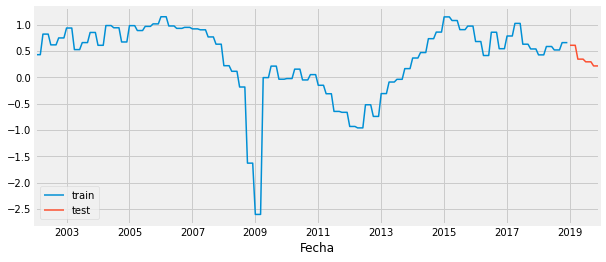

In [ ]:
# Separación datos train-test
# ==============================================================================
steps = 12
dataset_train = dataset[:-steps]
dataset_test  = dataset[-steps:]

print(f"Fechas train : {dataset_train.index.min()} --- {dataset_train.index.max()}  (n={len(dataset_train)})")
print(f"Fechas test  : {dataset_test.index.min()} --- {dataset_test.index.max()}  (n={len(dataset_test)})", '\n')

fig, ax = plt.subplots(figsize=(9, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
# RANDOM FOREST
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 24
                )
forecaster.fit(y=dataset_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2002-01-31 00:00:00'), Timestamp('2018-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-29 09:50:02 
Last fit date: 2023-01-29 09:50:03 
Skforecast version: 0.6.0 

In [ ]:
# Predicciones
# ==============================================================================
steps = 12
predicciones = forecaster.predict(steps=steps)
predicciones

2019-01-31    0.752667
2019-02-28    0.768767
2019-03-31    0.779204
2019-04-30    0.800628
2019-05-31    0.812563
2019-06-30    0.816824
2019-07-31    0.904401
2019-08-31    0.968680
2019-09-30    0.971324
2019-10-31    0.963075
2019-11-30    0.952752
2019-12-31    0.946143
Freq: M, Name: pred, dtype: float64

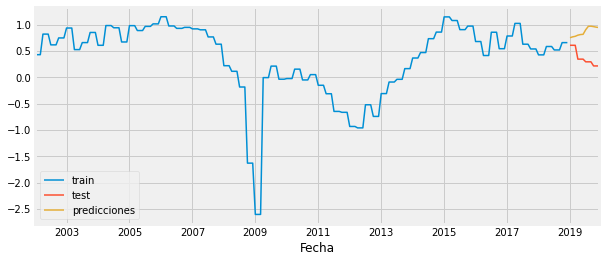

In [ ]:
# Gráfico Predicciones
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test Random Forest
# ==============================================================================
error_mse = mean_squared_error(
                y_true = dataset_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}", '\n')

Error de test (mse): 0.3026997718731664 



In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 12
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 24 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [1, 48]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [1, 3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = dataset_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(dataset_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

# Resultados Grid Search
# ==============================================================================
resultados_grid
print("los mejores resultados se dan: Usando una ventana temporal de 1 lag", '\n',
"y un Random Forest de:(3 de profundidad y 100 estimadores)", '\n' "esto se ve en variable explorer: resultados grid")

Number of models compared: 16.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:50<00:00, 55.15s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.12250021701253355

los mejores resultados se dan: Usando una ventana temporal de 1 lag 
 y un Random Forest de:(3 de profundidad y 100 estimadores) 
esto se ve en variable explorer: resultados grid


In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 1
             )

forecaster.fit(y=dataset_train['y'])

2019-01-31    0.634753
2019-02-28    0.615426
2019-03-31    0.615426
2019-04-30    0.615426
2019-05-31    0.615426
2019-06-30    0.615426
2019-07-31    0.615426
2019-08-31    0.615426
2019-09-30    0.615426
2019-10-31    0.615426
2019-11-30    0.615426
2019-12-31    0.615426
Freq: M, Name: pred, dtype: float64
Error de test (mse) 0.08351511493915394


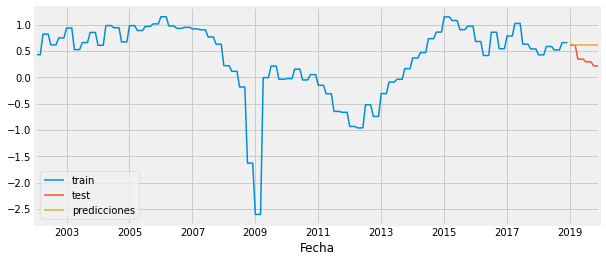

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)
print(predicciones)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();


# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = dataset_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

In [ ]:
# Backtesting
# ==============================================================================
steps = 3
n_backtesting = steps*4 #Se separan el útltimo año para el backtest
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = dataset['y'],
                                    initial_train_size = len(dataset) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}",'\n')
predicciones_backtest


Information of backtesting process
----------------------------------
Number of observations used for initial training: 204
Number of observations used for backtesting: 12
    Number of folds: 4
    Number of steps per fold: 3

Data partition in fold: 0
    Training:   2002-01-31 00:00:00 -- 2018-12-31 00:00:00  (n=204)
    Validation: 2019-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=3)
Data partition in fold: 1
    Training:   2002-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=207)
    Validation: 2019-04-30 00:00:00 -- 2019-06-30 00:00:00  (n=3)
Data partition in fold: 2
    Training:   2002-01-31 00:00:00 -- 2019-06-30 00:00:00  (n=210)
    Validation: 2019-07-31 00:00:00 -- 2019-09-30 00:00:00  (n=3)
Data partition in fold: 3
    Training:   2002-01-31 00:00:00 -- 2019-09-30 00:00:00  (n=213)
    Validation: 2019-10-31 00:00:00 -- 2019-12-31 00:00:00  (n=3)

Error de backtest: 0.02033446421513326 



,pred
2019-01-31,0.634753
2019-02-28,0.615426
2019-03-31,0.615426
2019-04-30,0.608096
2019-05-31,0.608096
2019-06-30,0.608096
2019-07-31,0.347249
2019-08-31,0.347249
2019-09-30,0.347249
2019-10-31,0.315718


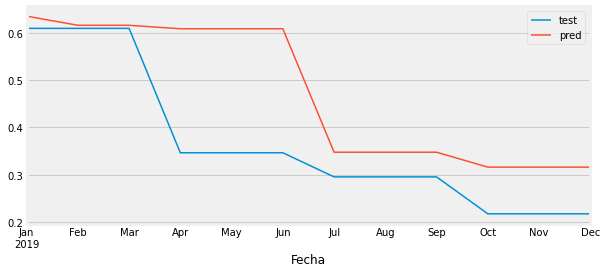

In [ ]:
# Gráfico del Backtesting
# ========================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_test['y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones_backtest')
ax.legend();


In [ ]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

,feature,importance
0,lag_1,1.0


In [ ]:
variables_exog = ['EuriborM', 'ParoT', 'SalarioMedio', 'IPC','CTotalConsumo']
fin_train = '31/12/2018'
forecaster.fit(
    y= dataset.loc[:fin_train:,'y'],
    exog= dataset.loc[:fin_train:, variables_exog]
    ) # Entrenamiento con conjuntos de train
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=3, random_state=123) 
Lags: [1] 
Transformer for y: None 
Transformer for exog: None 
Window size: 1 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['EuriborM', 'ParoT', 'SalarioMedio', 'IPC', 'CTotalConsumo'] 
Training range: [Timestamp('2002-01-31 00:00:00'), Timestamp('2018-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-29 09:51:54 
Last fit date: 2023-01-29 09:51:55

In [ ]:
exog_siguientes_12meses = dataset_test[variables_exog][:12]

predicciones = forecaster.predict(steps=12, exog=exog_siguientes_12meses)
predicciones

2019-01-31    0.623131
2019-02-28    0.601345
2019-03-31    0.597902
2019-04-30    0.615199
2019-05-31    0.601345
2019-06-30    0.597902
2019-07-31    0.599133
2019-08-31    0.597902
2019-09-30    0.597902
2019-10-31    0.615199
2019-11-30    0.601345
2019-12-31    0.597902
Freq: M, Name: pred, dtype: float64

In [ ]:
# Backtesting
# ==============================================================================
steps = 3
n_backtesting = steps*4 #Se separan el útltimo año para el backtest
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = dataset['y'],
                                    exog               = dataset[variables_exog],
                                    initial_train_size = len(dataset) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}",'\n')
predicciones_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 204
Number of observations used for backtesting: 12
    Number of folds: 4
    Number of steps per fold: 3

Data partition in fold: 0
    Training:   2002-01-31 00:00:00 -- 2018-12-31 00:00:00  (n=204)
    Validation: 2019-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=3)
Data partition in fold: 1
    Training:   2002-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=207)
    Validation: 2019-04-30 00:00:00 -- 2019-06-30 00:00:00  (n=3)
Data partition in fold: 2
    Training:   2002-01-31 00:00:00 -- 2019-06-30 00:00:00  (n=210)
    Validation: 2019-07-31 00:00:00 -- 2019-09-30 00:00:00  (n=3)
Data partition in fold: 3
    Training:   2002-01-31 00:00:00 -- 2019-09-30 00:00:00  (n=213)
    Validation: 2019-10-31 00:00:00 -- 2019-12-31 00:00:00  (n=3)

Error de backtest: 0.026522646064880324 



,pred
2019-01-31,0.623131
2019-02-28,0.601345
2019-03-31,0.597902
2019-04-30,0.612999
2019-05-31,0.597372
2019-06-30,0.595476
2019-07-31,0.370154
2019-08-31,0.417020
2019-09-30,0.523142
2019-10-31,0.343685


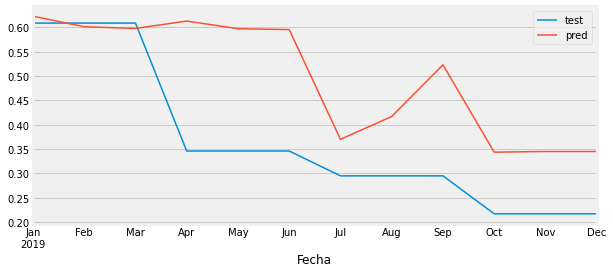

In [ ]:
# Gráfico del Backtesting
# ========================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_test['y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones_backtest')
ax.legend();